In [1]:
# import tools for analyzing timeseries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss


In [6]:
# Please place the sample data to your preferred directory
quarterly = pd.read_excel('TAF_2_Stationary_Time_Series_PES_quarterly.xls',index_col=0)
usbond, tbill = quarterly['r5'], quarterly['Tbill']
spread = usbond - tbill
spread.index = pd.to_datetime(spread.index)
spread.index.freq = 'QS-OCT'


C:\Users\kkksk\AppData\Local\Temp\ipykernel_8492\546256611.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  spread.index = pd.to_datetime(spread.index)


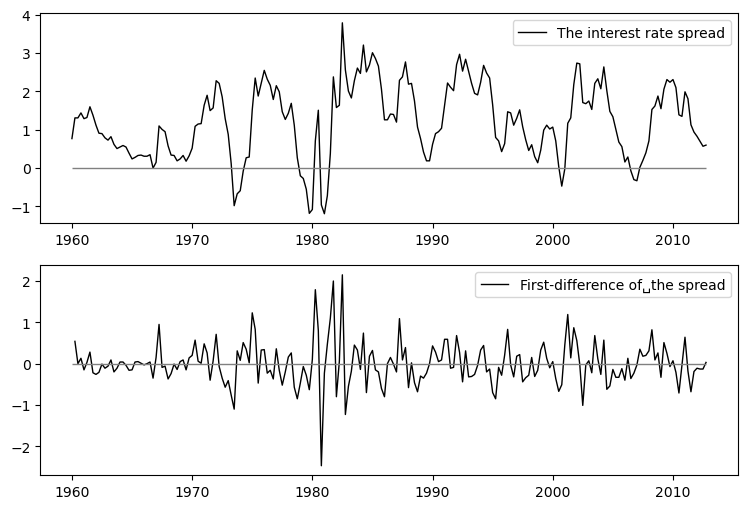

In [8]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 2*3))
axes[0].plot(spread,color='black',linewidth=1,label='The interest rate spread')
axes[0].hlines(xmin=spread.index[0],xmax=spread.index[-1],y=0,color='gray',linewidth=1)
axes[0].legend()
axes[1].plot(spread.diff(),color='black',linewidth=1,label='First-difference of␣the spread')
axes[1].hlines(xmin=spread.index[0],xmax=spread.index[-1],y=0,color='gray',linewidth=1)
axes[1].legend()
plt.show()


In [10]:
def adf_test(dataframe):
    result = adfuller(dataframe)
    print(f'Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical values: {result[4]}')
adf_test(spread)
print('---'*40)
adf_test(spread.diff().dropna())

Statistics: -4.7026036966556335
p-value: 8.3210125042279e-05
Critical values: {'1%': -3.4631437906252636, '5%': -2.8759570379821047, '10%': -2.574454682874228}
------------------------------------------------------------------------------------------------------------------------
Statistics: -5.688123744797404
p-value: 8.18910560067691e-07
Critical values: {'1%': -3.463476079125, '5%': -2.876102355, '10%': -2.574532225}


In [11]:
def kpss_test(dataframe):
    result = kpss(dataframe)
    print(f'Statistics: {result[0]}')
    print(f'bounded p-value: {result[1]}')
    print(f'Critical values: {result[3]}')
kpss_test(spread)
print('---'*40)
kpss_test(spread.diff().dropna())

Statistics: 0.23250592825595803
bounded p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------
Statistics: 0.020995623795567485
bounded p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(
C:\Anaconda\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


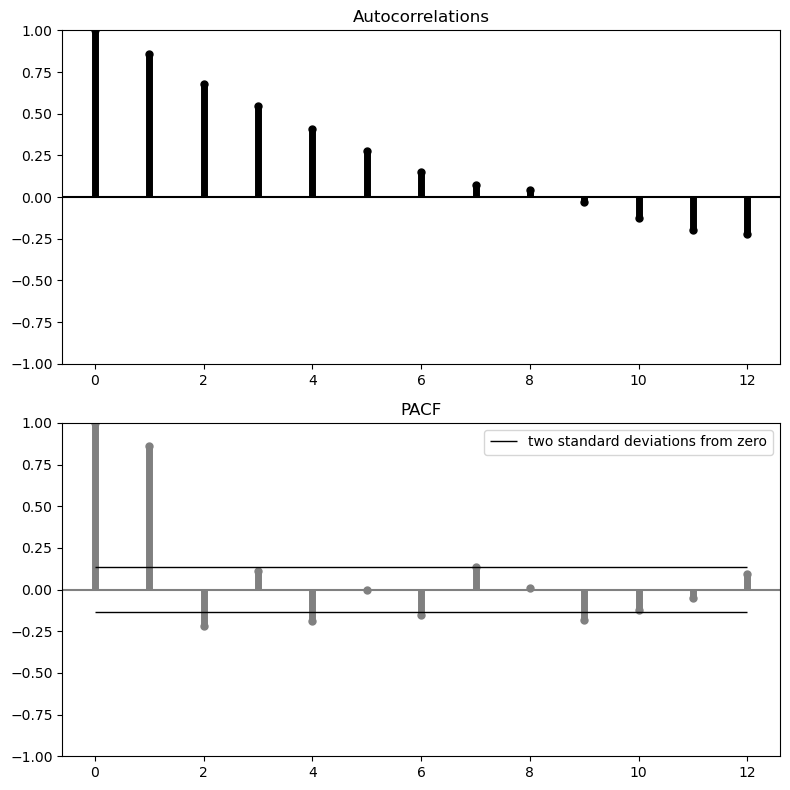

In [14]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 2*4))
plot_acf(spread, lags=12, ax=axes[0], title='Autocorrelations',color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
plot_pacf(spread, lags=12, ax=axes[1], method='ols', title='PACF',color='gray',vlines_kwargs={'colors':'gray','linewidth':5}, alpha=None)
axes[1].hlines(xmin=0,xmax=12,y=2*np.sqrt(1/len(spread)),label='two standard deviations from zero',color='black',linewidth=1)
axes[1].hlines(xmin=0,xmax=12,y=-2*np.sqrt(1/len(spread)),color='black',linewidth=1)
axes[1].legend()
plt.tight_layout()
plt.show()


In [16]:
# Define a function to get the maximum value(s) from an element in the set
def get_max_value(element):
    if isinstance(element, int) or isinstance(element, float):
        return element
    else:
        return max(element)


In [18]:
lag_list = [(list(range(1,8)), 0, 0), (list(range(1,7)), 0, 0), ([1,2], 0, 0),([1,2,7], 0, 0), (1, 0, 1), (2, 0, 1), (2, 0, [1,7])]
# AR(7), AR(6), AR(2), p=1,2,7 , ARMA(1,1), ARMA(2,1), p=2;ma=(1,7)
# We will estimate 7 different models.
summary_table = dict()
idx=0
num_of_obs = len(spread[7:])
for lag in lag_list:
# SSE i.e SSR, AIC, SBC, Ljung–Box Q-statistics of the residual autocorrelations for lag:={4, 8, 12}.
    temp_perf_dict = {key: key for key in ['SSE','AIC','SBC','Q(4)','Q(8)','Q(12)']}
# Get the maximum value(s) from each element in the set
    max_values = [get_max_value(elem) for elem in lag]
    max_element = max(max_values)
# We use spread[7-max_element:] to estimate each equation over the␣1961Q4-2012Q4.
    res = ARIMA(endog = spread[7-max_element:], order=lag, trend='c').fit(method='innovations_mle')
# Use Durbin–Levinson algorithm. You can also use other estimation method.
    temp_perf_dict['SSE'] = round(res.sse,2)
# Note that since we assume the model errors are IID according to a normal␣ distribution, the BIC and AIC formula is bit different from a general form.
    temp_perf_dict['AIC'] = round(num_of_obs*np.log(res.sse) + 2*len(res.params),2)
    temp_perf_dict['SBC'] = round(num_of_obs*np.log(res.sse) + len(res.params)*np.log(num_of_obs),2)
# Lijung-box Q-statistics for lag 4,8,12
    q_statistics = res.test_serial_correlation(method='ljungbox',lags=12)[0]
    temp_perf_dict['Q(4)'] = {'q_stats' : round(q_statistics[0][3],2), 'p_val': round(q_statistics[1][3],2)}
    temp_perf_dict['Q(8)'] = {'q_stats' : round(q_statistics[0][7],2), 'p_val': round(q_statistics[1][7],2)}
    temp_perf_dict['Q(12)'] = {'q_stats' : round(q_statistics[0][11],2),'p_val': round(q_statistics[1][11],2)}
    for param_name, param in zip(res.params.index, res.params):
        temp_perf_dict[param_name] = {'coef':round(param,2), 't_stats': round(res.tvalues[param_name],2)}
        hashable_order = tuple([tuple(order) if isinstance(order,list) == True else order for order in res.specification['order']]) # make res.specification['order'] hashable.
        summary_table[hashable_order] = temp_perf_dict

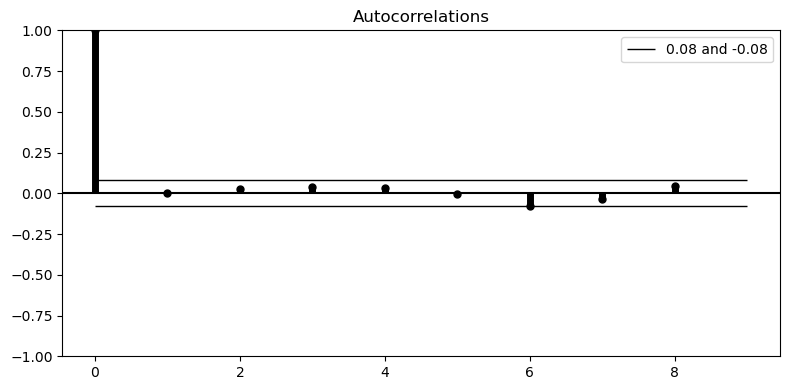

In [21]:
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
# the ACF of the last model's residuals.
plot_acf(res.resid, lags=8, ax=axes, title='Autocorrelations', color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
axes.hlines(xmin=0,xmax=9,y=0.08,label='0.08 and -0.08',color='black',linewidth=1)
axes.hlines(xmin=0,xmax=9,y=-0.08,color='black',linewidth=1)
axes.legend()
plt.tight_layout()
plt.show()


In [20]:
table_2_4 = pd.DataFrame()
for key, value in summary_table.items():
    temp_series = pd.Series(value, name=key)
    table_2_4 = pd.concat([table_2_4,temp_series],axis=1)


In [23]:
table_2_4.loc[['const','ar.L1','ar.L2','ar.L3','ar.L4','ar.L5','ar.L6','ar.L7','ma.L1','ma.L7','SSE','AIC','SBC','Q(4)','Q(8)','Q(12)'],:]
# For ordering the row of the table.


,"(7, 0, 0)","(6, 0, 0)","(2, 0, 0)","((1, 2, 7), 0, 0)","(1, 0, 1)","(2, 0, 1)","(2, 0, (1, 7))"
const,"{'coef': 1.2, 't_stats': 6.33}","{'coef': 1.21, 't_stats': 7.24}","{'coef': 1.2, 't_stats': 5.79}","{'coef': 1.2, 't_stats': 6.53}","{'coef': 1.21, 't_stats': 6.23}","{'coef': 1.2, 't_stats': 5.62}","{'coef': 1.19, 't_stats': 5.74}"
ar.L1,"{'coef': 1.11, 't_stats': 15.72}","{'coef': 1.09, 't_stats': 17.78}","{'coef': 1.04, 't_stats': 18.45}","{'coef': 1.03, 't_stats': 16.14}","{'coef': 0.76, 't_stats': 14.82}","{'coef': 0.42, 't_stats': 3.07}","{'coef': 0.34, 't_stats': 3.24}"
ar.L2,"{'coef': -0.44, 't_stats': -4.21}","{'coef': -0.42, 't_stats': -4.42}","{'coef': -0.22, 't_stats': -3.91}","{'coef': -0.2, 't_stats': -3.0}",NaN,"{'coef': 0.32, 't_stats': 2.48}","{'coef': 0.4, 't_stats': 4.18}"
ar.L3,"{'coef': 0.39, 't_stats': 4.52}","{'coef': 0.36, 't_stats': 4.26}",NaN,NaN,NaN,NaN,NaN
ar.L4,"{'coef': -0.29, 't_stats': -3.88}","{'coef': -0.24, 't_stats': -3.56}",NaN,NaN,NaN,NaN,NaN
ar.L5,"{'coef': 0.22, 't_stats': 2.24}","{'coef': 0.16, 't_stats': 2.08}",NaN,NaN,NaN,NaN,NaN
ar.L6,"{'coef': -0.29, 't_stats': -2.71}","{'coef': -0.14, 't_stats': -2.62}",NaN,NaN,NaN,NaN,NaN
ar.L7,"{'coef': 0.13, 't_stats': 1.87}",NaN,NaN,"{'coef': -0.03, 't_stats': -0.94}",NaN,NaN,NaN
ma.L1,NaN,NaN,NaN,NaN,"{'coef': 0.38, 't_stats': 5.75}","{'coef': 0.7, 't_stats': 6.17}","{'coef': 0.78, 't_stats': 10.93}"
ma.L7,NaN,NaN,NaN,NaN,NaN,NaN,"{'coef': -0.14, 't_stats': -3.73}"


In [25]:
# out-of-sample prediction with expanding rolling window.
checker = spread.index <= '2000-04-01'
train_set = spread[checker]
test_set = spread[~checker]
n_train = len(train_set)
n_test = len(test_set)
f1, f1_error = [], []
f2, f2_error = [], []
ground_truth = []
for i in range(n_test):
    crt_time = i + n_train
    x_train = spread[:crt_time]
    # iterate over the time series data, fitting the model on each expanding window of data
    model_1 = ARIMA(endog = x_train, order=(7,0,0), trend='c').fit(method='innovations_mle') # model 1
    model_2 = ARIMA(endog = x_train, order=(2,0,[1,7]), trend='c').fit(method='innovations_mle') # model 2
    # one-step-ahead forecasts
    forecast_1 = model_1.forecast(steps=1)
    forecast_2 = model_2.forecast(steps=1)
    # true one-step-ahead value
    y = spread[crt_time]
    ground_truth.append(y)
    f1.append(forecast_1[0])
    f1_error.append(y-forecast_1[0])
    f2.append(forecast_2[0])
    f2_error.append(y-forecast_2[0])

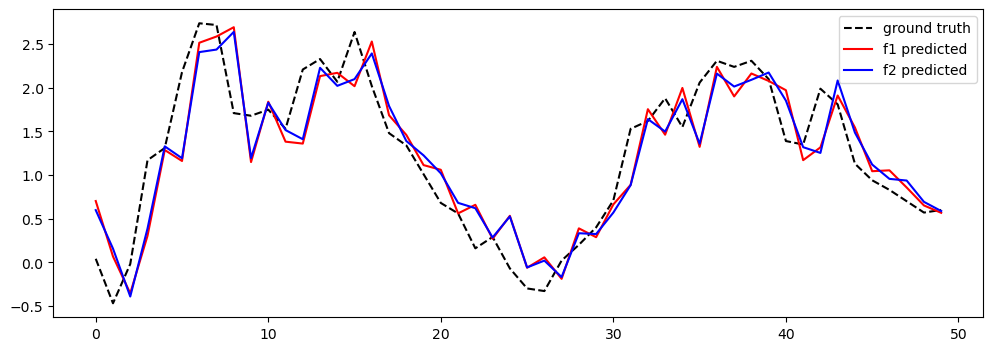

In [26]:
# plot the results
plt.figure(figsize=(12,4))
plt.plot(ground_truth, label='ground truth', color='k', linestyle='--')
plt.plot(f1, label='f1 predicted', color='r')
plt.plot(f2, label='f2 predicted', color='b')
plt.legend()
plt.show()


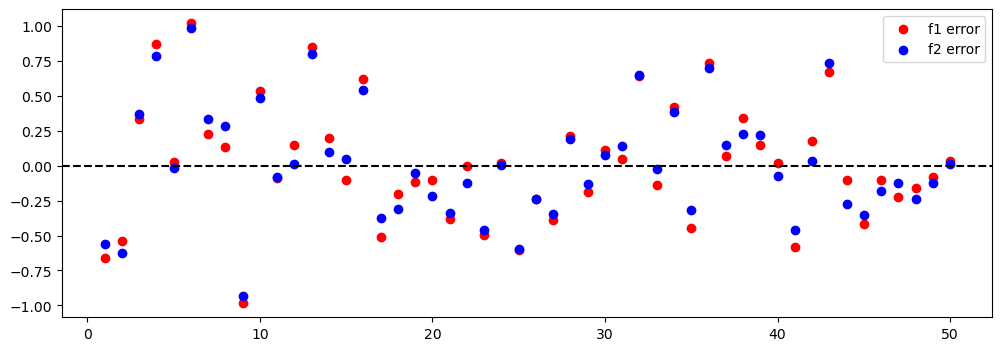

In [27]:
 # plot the results
plt.figure(figsize=(12,4))
plt.scatter(np.linspace(1,len(f1_error),len(f1_error)), f1_error, label='f1 error', color='r')
plt.scatter(np.linspace(1,len(f2_error),len(f2_error)), f2_error, label='f2 error', color='b')
plt.axhline(y=0, color='k', linestyle='--')
plt.legend()
plt.show()
